# Demo

This notebook provides a high-level overview of the **Online Retail Simulator** package and its capabilities.

## What is Online Retail Simulator?

A Python package for generating **synthetic e-commerce data** for:
- Testing and demos without exposing real business data
- ML model training with realistic retail patterns
- A/B test simulation and experimentation
- Teaching analytics and data science concepts

## Key Capabilities

- **Rule-based generation**: Fast, configurable synthetic data
- **ML-based synthesis**: Learn patterns from real data (optional SDV integration)
- **Reproducible results**: Seed control for deterministic output
- **8 product categories**: Electronics, Books, Clothing, and more
- **Funnel metrics**: Impressions, visits, cart adds, orders

## Setup

First, let's install the package (if running in Colab) and import the necessary libraries.

In [1]:
# Uncomment if running in Google Colab
# !pip install online-retail-simulator matplotlib seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from online_retail_simulator import simulate, load_job_results

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### Generate Sample Data

We'll generate 30 days of synthetic sales data with a simple configuration.

In [3]:
import yaml
import tempfile
import os

# Configuration for simulation
config = {
    "STORAGE": {"PATH": "output"},
    "RULE": {
        "CHARACTERISTICS": {
            "FUNCTION": "simulate_characteristics_rule_based",
            "PARAMS": {"num_products": 100, "seed": 42}
        },
        "METRICS": {
            "FUNCTION": "simulate_metrics_rule_based",
            "PARAMS": {
                "date_start": "2024-11-01",
                "date_end": "2024-11-30",
                "sale_prob": 0.7,
                "seed": 42
            }
        }
    }
}

# Write config to temp file and run simulation
with tempfile.NamedTemporaryFile(mode="w", suffix=".yaml", delete=False) as f:
    yaml.dump(config, f)
    config_path = f.name

try:
    job_info = simulate(config_path)
finally:
    os.unlink(config_path)

# Load results
results = load_job_results(job_info)
products_df = results["products"]
sales_df = results["sales"]

print(f"Generated {len(products_df)} products")
print(f"Generated {len(sales_df)} sales records")

Generated 100 products
Generated 3000 sales records


## Exploring the Generated Data

Let's look at the structure and contents of our synthetic dataset.

In [4]:
# Preview the sales data
print(f"Date range: {sales_df['date'].min()} to {sales_df['date'].max()}")
print(f"Categories: {sales_df['category'].nunique()}")
print(f"Total revenue: ${sales_df['revenue'].sum():,.2f}")
print()
sales_df.head(10)

Date range: 2024-11-01 to 2024-11-30
Categories: 8
Total revenue: $125,165.32



,asin,category,price,date,impressions,visits,cart_adds,ordered_units,revenue,average_selling_price
0,BRPOIG8F1C,Clothing,19.63,2024-11-01,10,1,0,0,0.00,0.00
1,BO6B9M80O2,Electronics,185.86,2024-11-01,0,0,0,0,0.00,0.00
2,BAK1VRJNVG,Sports & Outdoors,245.69,2024-11-01,100,12,2,1,245.69,245.69
3,BWWQC38HYF,Clothing,85.29,2024-11-01,25,3,0,0,0.00,0.00
4,BXMECOSFOG,Sports & Outdoors,251.38,2024-11-01,25,3,0,0,0.00,0.00
5,BXKXWNREK8,Food & Beverage,17.51,2024-11-01,0,0,0,0,0.00,0.00
6,BYR9OUDOCU,Books,18.17,2024-11-01,50,8,1,0,0.00,0.00
7,BNUN5Z3JQI,Food & Beverage,17.05,2024-11-01,200,28,5,1,17.05,17.05
8,B8Q1ZXOI65,Books,47.25,2024-11-01,0,0,0,0,0.00,0.00
9,BHJK1EYY37,Clothing,154.82,2024-11-01,50,8,2,5,774.10,154.82


### Revenue by Category

How is revenue distributed across product categories?

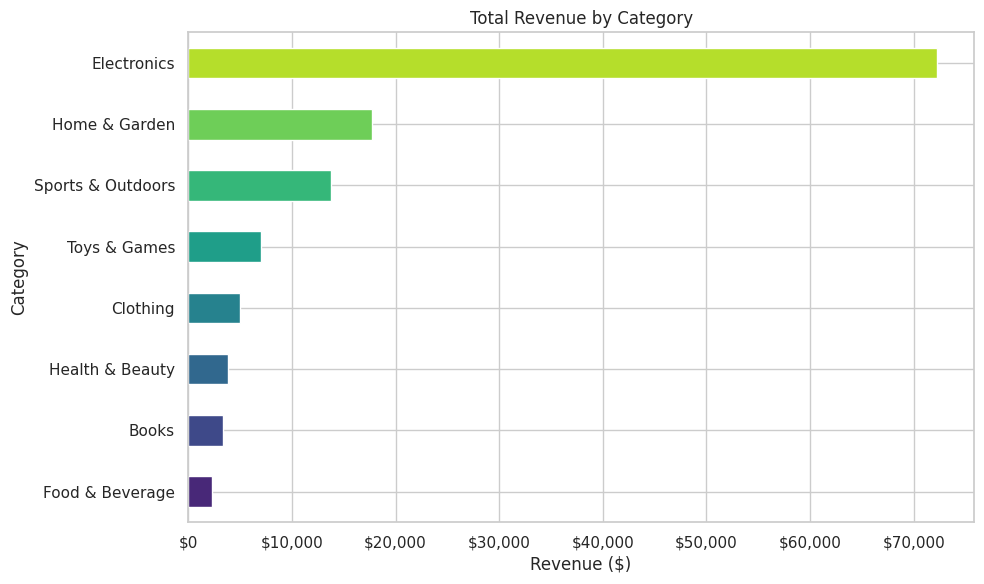

In [5]:
# Revenue by category
category_revenue = sales_df.groupby("category")["revenue"].sum().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
category_revenue.plot(kind="barh", ax=ax, color=sns.color_palette("viridis", len(category_revenue)))
ax.set_xlabel("Revenue ($)")
ax.set_ylabel("Category")
ax.set_title("Total Revenue by Category")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
plt.tight_layout()
plt.show()

### Daily Sales Trend

How do sales vary over time?

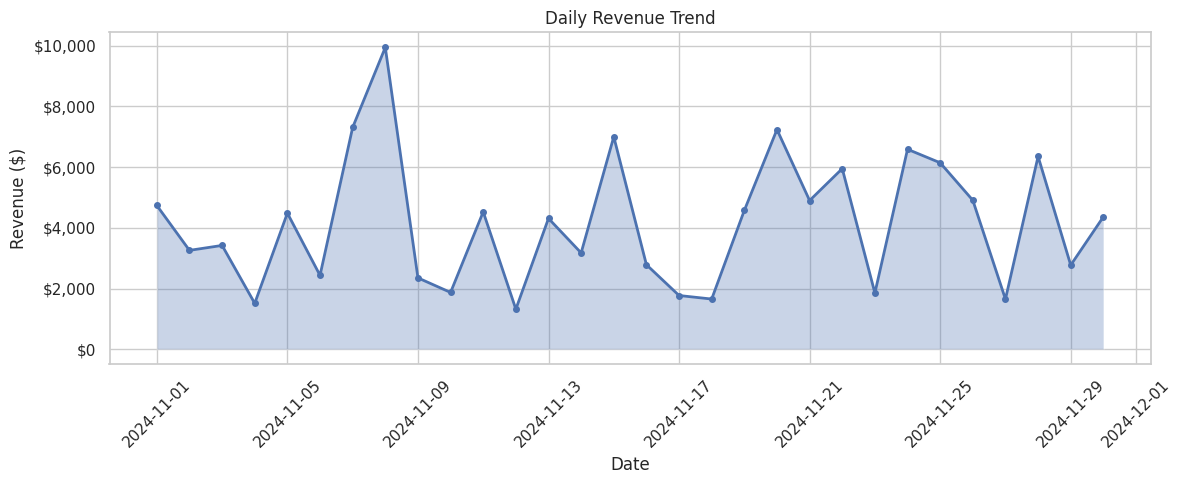

In [6]:
# Daily sales trend
daily_sales = sales_df.groupby("date").agg({
    "ordered_units": "sum",
    "revenue": "sum"
}).reset_index()
daily_sales["date"] = pd.to_datetime(daily_sales["date"])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(daily_sales["date"], daily_sales["revenue"], marker="o", linewidth=2, markersize=4)
ax.fill_between(daily_sales["date"], daily_sales["revenue"], alpha=0.3)
ax.set_xlabel("Date")
ax.set_ylabel("Revenue ($)")
ax.set_title("Daily Revenue Trend")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Conversion Funnel

The data includes full customer journey metrics: impressions, visits, cart adds, and orders.

Conversion Rates:
  Impressions → Visits: 13.8%
  Visits → Cart Adds: 16.3%
  Cart Adds → Orders: 39.5%
  Overall (Impressions → Orders): 0.89%


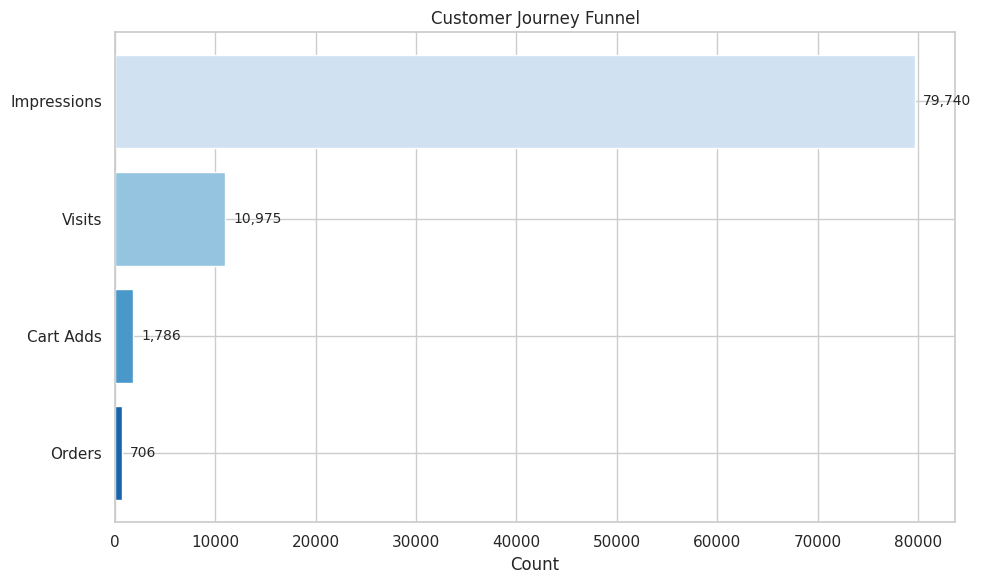

In [7]:
# Conversion funnel
funnel_data = {
    "Impressions": sales_df["impressions"].sum(),
    "Visits": sales_df["visits"].sum(),
    "Cart Adds": sales_df["cart_adds"].sum(),
    "Orders": sales_df["ordered_units"].sum()
}

stages = list(funnel_data.keys())
values = list(funnel_data.values())

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("Blues_r", len(stages))
bars = ax.barh(stages[::-1], values[::-1], color=colors)
ax.set_xlabel("Count")
ax.set_title("Customer Journey Funnel")

# Add value labels
for bar, val in zip(bars, values[::-1]):
    ax.text(val + max(values) * 0.01, bar.get_y() + bar.get_height() / 2,
            f"{val:,}", va="center", fontsize=10)

# Add conversion rates
print("Conversion Rates:")
print(f"  Impressions → Visits: {values[1]/values[0]*100:.1f}%")
print(f"  Visits → Cart Adds: {values[2]/values[1]*100:.1f}%")
print(f"  Cart Adds → Orders: {values[3]/values[2]*100:.1f}%")
print(f"  Overall (Impressions → Orders): {values[3]/values[0]*100:.2f}%")

plt.tight_layout()
plt.show()

## Descriptive Analysis

Let's dive deeper into the data patterns.

### Distribution of Order Values

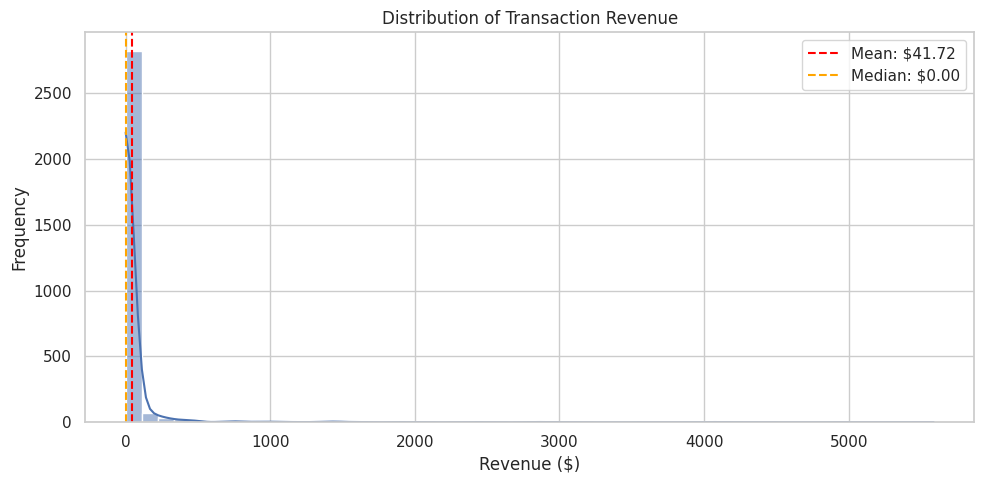

In [8]:
# Distribution of revenue per transaction
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(sales_df["revenue"], bins=50, kde=True, ax=ax)
ax.set_xlabel("Revenue ($)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Transaction Revenue")
ax.axvline(sales_df["revenue"].mean(), color="red", linestyle="--", label=f"Mean: ${sales_df['revenue'].mean():,.2f}")
ax.axvline(sales_df["revenue"].median(), color="orange", linestyle="--", label=f"Median: ${sales_df['revenue'].median():,.2f}")
ax.legend()
plt.tight_layout()
plt.show()

### Units per Order by Category

/tmp/ipykernel_885079/4176667629.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sales_df, x="category", y="ordered_units", order=order, palette="viridis", ax=ax)


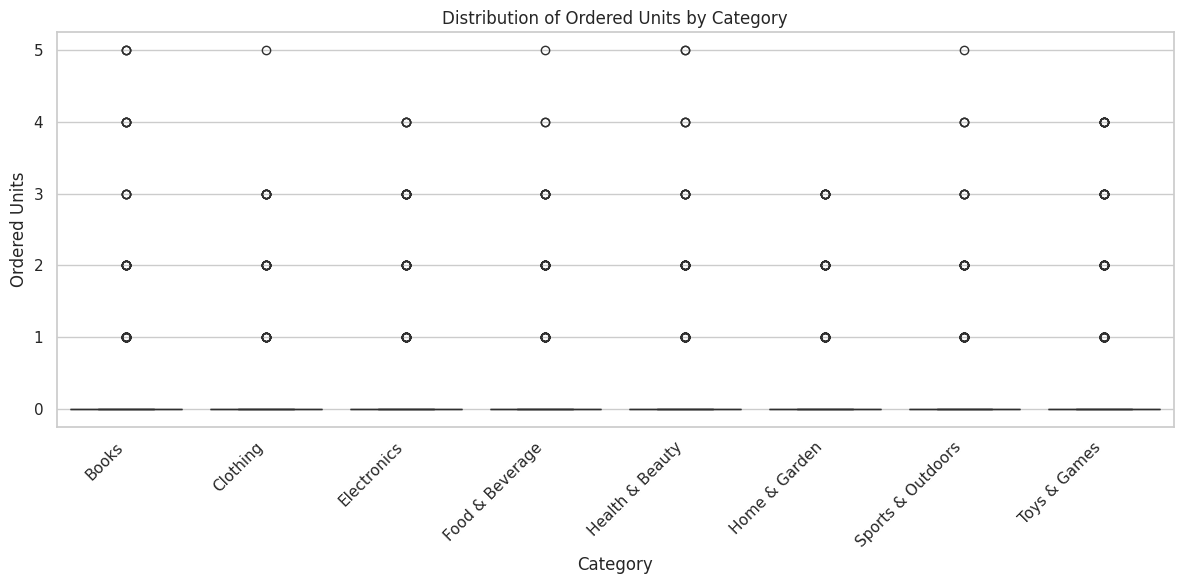

In [9]:
# Units per order by category
fig, ax = plt.subplots(figsize=(12, 6))
order = sales_df.groupby("category")["ordered_units"].median().sort_values().index
sns.boxplot(data=sales_df, x="category", y="ordered_units", order=order, palette="viridis", ax=ax)
ax.set_xlabel("Category")
ax.set_ylabel("Ordered Units")
ax.set_title("Distribution of Ordered Units by Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Correlation Between Metrics

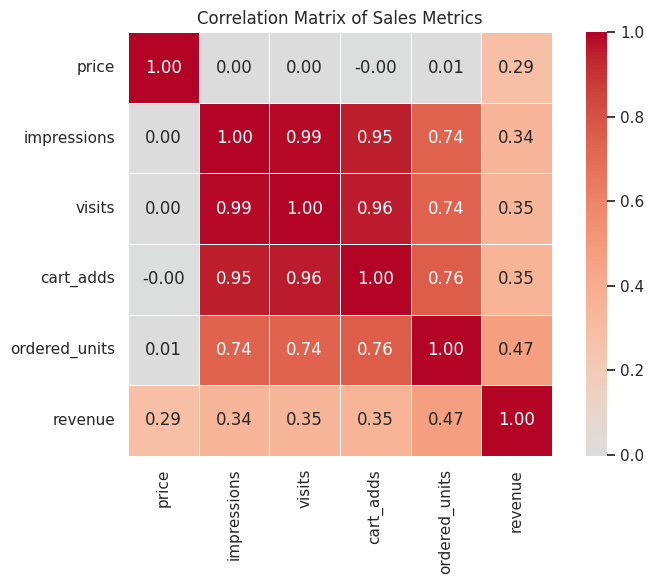

In [10]:
# Correlation heatmap of numeric metrics
numeric_cols = ["price", "impressions", "visits", "cart_adds", "ordered_units", "revenue"]
correlation_matrix = sales_df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0,
            fmt=".2f", square=True, ax=ax, linewidths=0.5)
ax.set_title("Correlation Matrix of Sales Metrics")
plt.tight_layout()
plt.show()

## Enrichment: Simulating Treatment Effects

The package can simulate treatment effects (e.g., A/B test outcomes) by boosting sales for a subset of products starting at a specific date.

In [11]:
from online_retail_simulator import enrich

# Enrichment config: boost sales by 50% for 30% of products starting Nov 15
enrichment_config = {
    "IMPACT": {
        "FUNCTION": "combined_boost",
        "PARAMS": {
            "effect_size": 0.5,
            "ramp_days": 7,
            "enrichment_fraction": 0.3,
            "enrichment_start": "2024-11-15",
            "seed": 42
        }
    }
}

# Write config and run enrichment
with tempfile.NamedTemporaryFile(mode="w", suffix=".yaml", delete=False) as f:
    yaml.dump(enrichment_config, f)
    enrich_config_path = f.name

try:
    enriched_job = enrich(enrich_config_path, job_info)
finally:
    os.unlink(enrich_config_path)

# Load enriched results
enriched_results = load_job_results(enriched_job)
enriched_df = enriched_results["enriched"]
print(f"Applied enrichment to {len(enriched_df)} records")

Applied enrichment to 3000 records


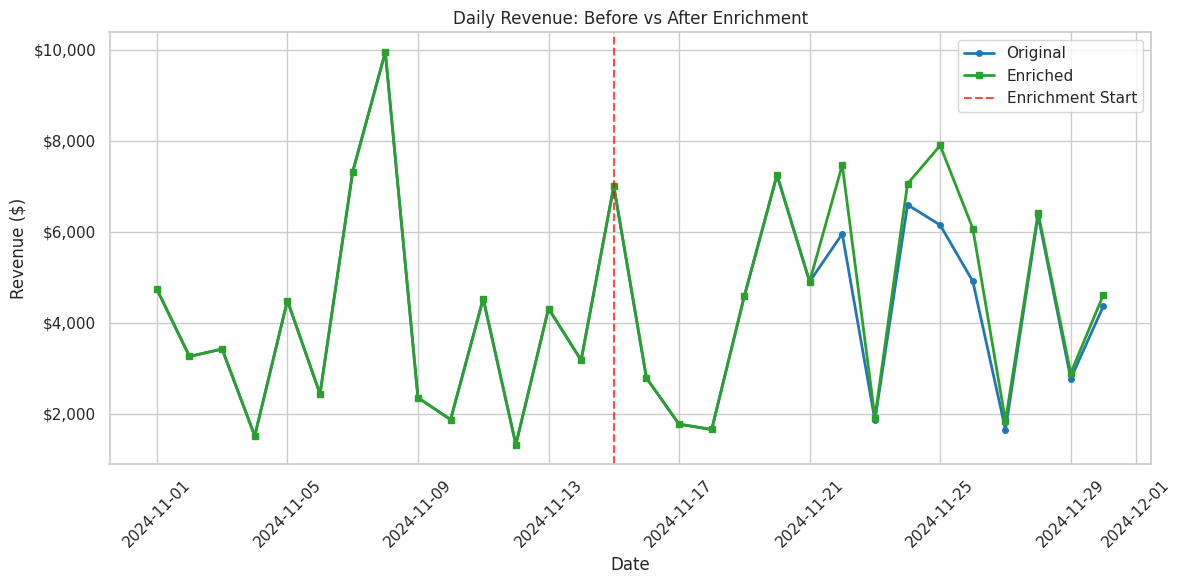


Post-enrichment period (Nov 15-30):
  Original revenue:  $70,508.22
  Enriched revenue:  $76,103.27
  Revenue lift:      7.9%


In [12]:
# Compare before and after: daily revenue time series
daily_original = sales_df.groupby("date")["revenue"].sum().reset_index()
daily_original["date"] = pd.to_datetime(daily_original["date"])
daily_original["type"] = "Original"

daily_enriched = enriched_df.groupby("date")["revenue"].sum().reset_index()
daily_enriched["date"] = pd.to_datetime(daily_enriched["date"])
daily_enriched["type"] = "Enriched"

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_original["date"], daily_original["revenue"], 
        marker="o", linewidth=2, markersize=4, label="Original", color="#1f77b4")
ax.plot(daily_enriched["date"], daily_enriched["revenue"], 
        marker="s", linewidth=2, markersize=4, label="Enriched", color="#2ca02c")

# Mark enrichment start
enrichment_start = pd.to_datetime("2024-11-15")
ax.axvline(enrichment_start, color="red", linestyle="--", alpha=0.7, label="Enrichment Start")

ax.set_xlabel("Date")
ax.set_ylabel("Revenue ($)")
ax.set_title("Daily Revenue: Before vs After Enrichment")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print lift metrics
post_start = enriched_df["date"] >= "2024-11-15"
original_post_revenue = sales_df[sales_df["date"] >= "2024-11-15"]["revenue"].sum()
enriched_post_revenue = enriched_df[post_start]["revenue"].sum()
lift = (enriched_post_revenue / original_post_revenue - 1) * 100

print(f"\nPost-enrichment period (Nov 15-30):")
print(f"  Original revenue:  ${original_post_revenue:,.2f}")
print(f"  Enriched revenue:  ${enriched_post_revenue:,.2f}")
print(f"  Revenue lift:      {lift:.1f}%")

## Next Steps

This overview covers the basics of generating and exploring synthetic retail data. For more details:

- **Full Documentation**: [Online Retail Simulator Docs](https://eisenhauerio.github.io/tools-catalog-generator/)
- **Configuration Reference**: Learn about all available parameters
- **API Reference**: Detailed function documentation
- **Demo Scripts**: See `demo/` directory for more examples

### Key Functions

```python
# Core simulation
simulate(config_path)         # Generate complete dataset
simulate_characteristics()    # Generate product catalog only
simulate_metrics()            # Generate sales metrics

# Enrichment
enrich(config_path, job)      # Apply treatment effects

# Results management
load_job_results(job)         # Load all results
list_jobs()                   # List saved jobs
cleanup_old_jobs(days=30)     # Clean up old outputs
```